<a href="https://colab.research.google.com/github/laura-str/p100_Cohort_Analysis/blob/main/Group_Practice_26_01_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Practice 2022-01-26

## The Tables

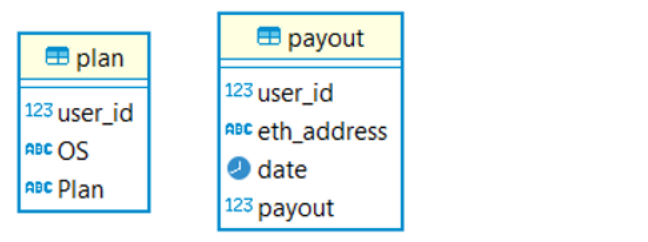

### Connecting to the Database

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
from warnings import filterwarnings
filterwarnings('ignore')

# configure the database connection
db_config = {'user': 'practicum_student',
             'pwd': 's65BlTKV3faNIGhmvJVzOqhs',
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,
             'db':  'data-analyst-eth-payouts-db'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])

# creating the enginge that will be used for the queries
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

### Looking at the Data

In [2]:
# a loop that fetches the first 5 rows for each table and displays them
print()
for table in engine.table_names():
    query = '''
                SELECT *
                FROM {}
                LIMIT 5;
            '''.format(table)
    
    head = pd.io.sql.read_sql(query, con = engine)
    
    print('\033[1m' + table + '\033[0m')
    display(head)
    print()
    print()


payout


,user_id,eth_address,date,payout
0,1005,0x4f9117b14426ac44ead4eaef0223830cb16bdb07,2020-07-27,1.68113
1,1005,0xccbe3f17a61f0e8ef05b04dc0c3f510522df6cc8,2020-09-04,2.27831
2,1020,0x2e22950c26899fd0dc0c593b147f6beb7f1c0c37,2020-11-11,0.25199
3,1020,0x2081974d67307ec737dd13c60b524ca4d644ec1d,2020-09-30,2.21076
4,1021,0x370ff36440a36825279db341c6b85bc0371e7c3f,2020-12-10,1.47999




plan


,user_id,OS,Plan
0,1005,Windows,Free
1,1020,MAC,Free
2,1021,Linux,Premium
3,1041,Linux,Free
4,1048,Windows,Free


### Storing the tables as pandas Dataframes

In [3]:
query = '''
            SELECT *
            FROM "payout";
        '''

payout =  pd.io.sql.read_sql(query, con = engine)


query = '''
            SELECT *
            FROM "plan";
        '''

plan = pd.io.sql.read_sql(query, con = engine)

# Questions

## 1. How many users got paid?

#### SQL

In [4]:
query = '''
            SELECT COUNT(DISTINCT("user_id"))
            FROM "payout";
        '''

pd.io.sql.read_sql(query, con = engine)

,count
0,433


#### Python

In [5]:
payout['user_id'].nunique()

433

## 2. Show the 5 users with the highest total payouts 

#### SQL

In [6]:
query = '''
            SELECT "user_id", SUM("payout") AS total_payout
            FROM "payout"
            GROUP BY "user_id"
            ORDER BY total_payout DESC
            LIMIT 5;
        '''

pd.io.sql.read_sql(query, con = engine)

,user_id,total_payout
0,1537,10.74169
1,3051,9.73121
2,1512,8.80816
3,1127,8.78861
4,4848,8.42445


#### Python

In [7]:
payout.groupby('user_id').agg({'payout':'sum'}).nlargest(5, 'payout').reset_index()

,user_id,payout
0,1537,10.74169
1,3051,9.73121
2,1512,8.80816
3,1127,8.78861
4,4848,8.42445


## 3. Which plan is the most popular? 

#### SQL

In [8]:
query = '''
            SELECT "Plan", COUNT(*)
            FROM "plan"
            GROUP BY "Plan";
        '''

pd.io.sql.read_sql(query, con = engine)

,Plan,count
0,Free,220
1,Premium,213


#### Python

In [9]:
plan['Plan'].value_counts()

Free       220
Premium    213
Name: Plan, dtype: int64

## 4. Which plan is the most popular amongst Linux users?

#### SQL

In [10]:
query = '''
            SELECT "Plan", COUNT(*)
            FROM "plan"
            WHERE "OS" = 'Linux'
            GROUP BY "Plan";
        '''

pd.io.sql.read_sql(query, con = engine)

,Plan,count
0,Free,68
1,Premium,76


#### Python

In [11]:
plan.query('OS == "Linux"')['Plan'].value_counts()

Premium    76
Free       68
Name: Plan, dtype: int64

## 5. What is the percentage of payout between the different plans? 

#### SQL

In [12]:
query = '''
            SELECT "Plan",
            SUM("payout") AS total_payout,
            ROUND(SUM("payout")/(SELECT SUM("payout") FROM "payout") * 100, 2) pct_payout
            FROM "plan"
            LEFT JOIN "payout"
            USING("user_id")
            GROUP BY "Plan";
        '''

pd.io.sql.read_sql(query, con = engine)

,Plan,total_payout,pct_payout
0,Free,488.68999,53.97
1,Premium,416.76178,46.03


#### Python

In [13]:
combined = payout.merge(plan, on = "user_id")
payout_by_plan = combined.groupby("Plan").agg({'payout':'sum'}).reset_index()

payout_by_plan['pct_payout'] = round(100 * payout_by_plan['payout'] / payout_by_plan['payout'].sum(), 2)

payout_by_plan

,Plan,payout,pct_payout
0,Free,488.68999,53.97
1,Premium,416.76178,46.03


## 6. What is the average payout amount per user for each of the OS in June 2020?

#### SQL

In [14]:
query = ''' WITH avg_payout AS (
                SELECT "user_id", SUM("payout") AS "payout"
                FROM "payout"
                WHERE "date" BETWEEN '2020-07-01' AND '2020-07-31'
                GROUP BY "user_id")
            
            SELECT "OS", AVG("payout")
            FROM avg_payout
            LEFT JOIN "plan"
            USING("user_id")
            GROUP BY "OS";
        '''

pd.io.sql.read_sql(query, con = engine)

,OS,avg
0,Linux,2.059855
1,Windows,1.735200
2,MAC,1.804590


#### Python

In [15]:
user_payout = payout[(payout['date'] >= "2020-07-01")
                     & (payout['date'] < "2020-08-01")].groupby("user_id").agg({"payout":"sum"})

user_payout = user_payout.merge(plan, how = "left", on = "user_id")

user_payout.groupby("OS").agg({"payout":"mean"}).reset_index()

,OS,payout
0,Linux,2.059855
1,MAC,1.804591
2,Windows,1.735200
